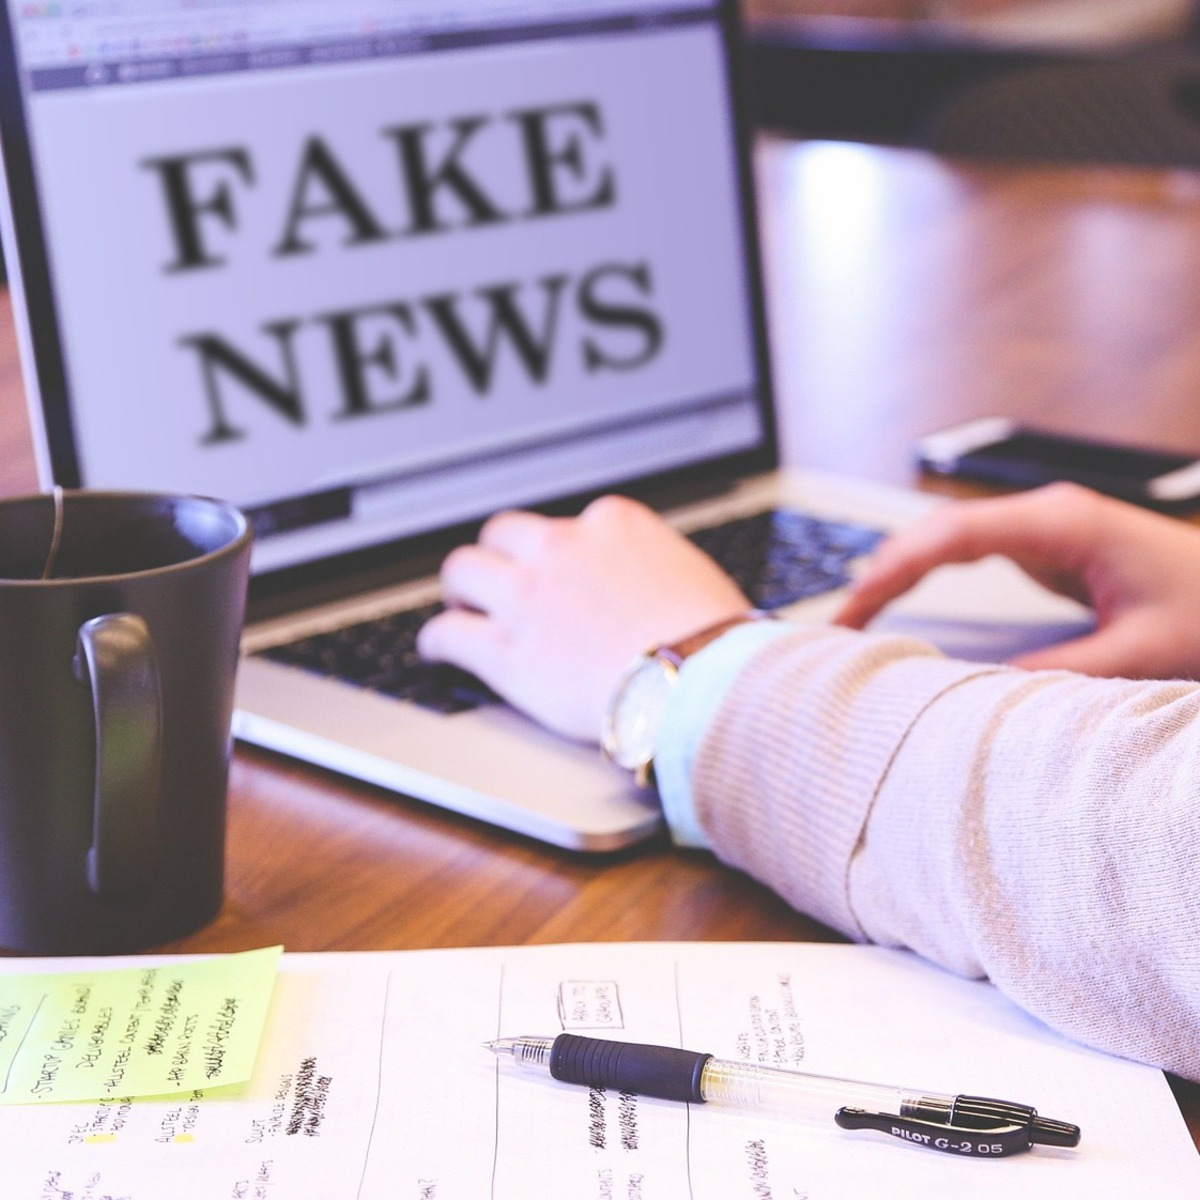

Решение датасета https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data

# 1. Импорт данных и библиотек

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
fakeNews = pd.read_csv("Fake.csv") # Загружаем фейковые новости
fakeNews.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
trueNews = pd.read_csv("True.csv") # Загружаем правдивые новости
trueNews.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Данные о признаках в датасете:

    1. title   - заголовок новости
    2. text    - содержание новости
    3. subject - категория новости
    4. date    - дата выпуска новости

# 2. EDA (Разведочный анализ данных)

In [4]:
trueNews.info() # Выведем информацию о правдивых новостях

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [5]:
fakeNews.info() # Выведем информацию о фейковых новостях

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Можно увидеть, что в данных отсутствуют пропуски

<Axes: xlabel='count', ylabel='subject'>

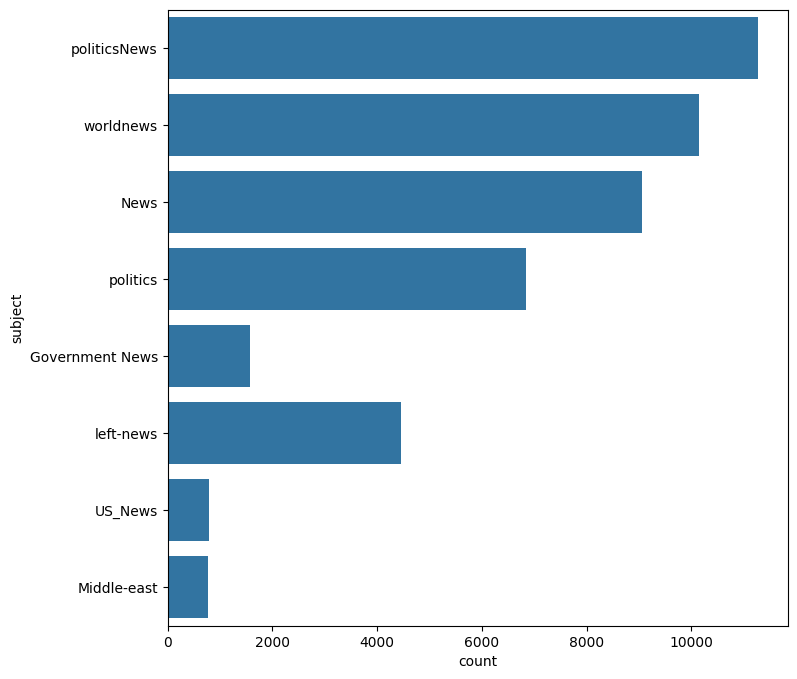

In [6]:
plt.figure(figsize=(8, 8))
sns.countplot(data=pd.concat([trueNews,fakeNews]).reset_index(drop = True), y='subject')

In [7]:
print(f"""Доля достоверных новостей в датасете: {round(trueNews.size/(trueNews.size+fakeNews.size)*100, 4)} %
Доля фейковых новостей в датасете: {round(fakeNews.size/(trueNews.size+fakeNews.size)*100, 4)} %""")

Доля достоверных новостей в датасете: 47.7015 %
Доля фейковых новостей в датасете: 52.2985 %


# 3. Обработка данных

In [8]:
trueNews['isFake'] = 0 # Добавим целевую метрику 
trueNews.head()

,title,text,subject,date,isFake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [9]:
fakeNews['isFake'] = 1 # Добавим целевую метрику 
fakeNews.head()

,title,text,subject,date,isFake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [10]:
df = pd.concat([trueNews,fakeNews]).reset_index(drop = True) # соеденим два DataFrame в один
df

,title,text,subject,date,isFake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [11]:
df.drop('date', axis=1, inplace=True) # Уберём дату т.к она не несёт информативности
df

,title,text,subject,isFake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0
...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,1


In [12]:
df['original'] = df['title'] + df['text'] # Соединим заголовок и содержание новости
df.head()

,title,text,subject,isFake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...


In [13]:
nltk.download('stopwords') # Скачаем слова, которые не несут информативности

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\k1rsn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop_words = stopwords.words('english') # Выберим английские слова

In [15]:
def preprocessing(text):
    """
    Функция позволяет получить слова, которые несут основной смысл новости
    Input:
        text - текст статьи
    Return:
        result - словарь слов
    """
    result = []
    for word in re.findall(r'\w+', text):
        if len(word) > 3 and word not in stop_words:
            result.append(word)
    return result

In [16]:
df['clean'] = df['original'].apply(lambda x: preprocessing(x)) # Применим функцию ко всей новости
df['clean'][0] # Выведим пример одной новости

['budget',
 'fight',
 'looms',
 'Republicans',
 'flip',
 'fiscal',
 'scriptWASHINGTON',
 'Reuters',
 'head',
 'conservative',
 'Republican',
 'faction',
 'Congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'Sunday',
 'urged',
 'budget',
 'restraint',
 '2018',
 'keeping',
 'sharp',
 'pivot',
 'among',
 'Republicans',
 'Representative',
 'Mark',
 'Meadows',
 'speaking',
 'Face',
 'Nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'January',
 'When',
 'return',
 'holidays',
 'Wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'even',
 'November',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'Republicans',
 'seek',
 'keep',
 'control',
 'Congress',
 'President',
 'Donald',
 'Trump',
 'Republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 

In [17]:
df # Посмотрим на получившийся датасет

,title,text,subject,isFake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, Republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, Mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...,"[Senior, Republican, senator, Mueller, WASHING..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...,"[Russia, probe, helped, Australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...,"[Trump, wants, Postal, Service, charge, much, ..."
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,1,McPain: John McCain Furious That Iran Treated ...,"[McPain, John, McCain, Furious, That, Iran, Tr..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[JUSTICE, Yahoo, Settles, mail, Privacy, Class..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[Sunnistan, Allied, Safe, Zone, Plan, Take, Te..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,1,How to Blow $700 Million: Al Jazeera America F...,"[Blow, Million, Jazeera, America, Finally, Cal..."


In [18]:
# Получим все слова из новостей
word_list = []
for record in df.clean:
    for word in record:
        word_list.append(word)

In [19]:
print(f"Всего слов собрано {len(word_list)}")

Всего слов собрано 10234412


In [20]:
unique_words = set(word_list)
print(f"Количество уникальных слов {len(unique_words)}, что является {round(len(unique_words)/len(word_list)*100, 4)} % от всех слов")

Количество уникальных слов 163594, что является 1.5985 % от всех слов


In [21]:
df['original'][0] # Выведим уникальную новость

'As U.S. budget fight looms, Republicans flip their fiscal scriptWASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

In [22]:
# Соединим все слова в единый текст
df['clean_text'] = df.clean.apply(lambda x: " ".join(x))
df['clean_text'][0] # Выведем пример обработанной новости

'budget fight looms Republicans flip fiscal scriptWASHINGTON Reuters head conservative Republican faction Congress voted month huge expansion national debt cuts called fiscal conservative Sunday urged budget restraint 2018 keeping sharp pivot among Republicans Representative Mark Meadows speaking Face Nation drew hard line federal spending lawmakers bracing battle January When return holidays Wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even November congressional election campaigns approach Republicans seek keep control Congress President Donald Trump Republicans want budget increase military spending Democrats also want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection Trump administration already willing going increase defense discretionary spending percent Meadows chairman small influential House Freedom Caucus said program D

# 4. Формирование выборок и обучение модели

In [23]:
# Сформируем выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.clean_text, df.isFake, test_size=0.2, random_state=42) 

In [24]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stop_words)

# Обучаем CountVectorizer на всех новостях
vectorizer.fit(X_train.values.astype('U'))
vectorizer.fit(X_test.values.astype('U'))

# Трансформируем новости в массив id-шников слов
X_train_vectorizer = vectorizer.transform(X_train.values.astype('U')).toarray()
X_test_vectorizer = vectorizer.transform(X_test.values.astype('U')).toarray()

In [25]:
%%time
svc = SVC()
svc.fit(X_train_vectorizer, y_train)

CPU times: total: 6min 33s
Wall time: 10min 10s


SVC()

In [26]:
predict = svc.predict(X_test_vectorizer)
print(f"Точность модели {svc.__class__.__name__}: {round(accuracy_score(y_test, predict)*100,4)} %")

Точность модели SVC: 99.2205 %


По итогу модель выдала точность в 99.2205%, что является отличным результатом